In [107]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime, timedelta

__author__ = "Rhishabh Hattarki"
__date__ = "11 October 2023"
__assignment = "SER594: Homework 3 Q3 Programming"

In [108]:
# load csv file,
# columns is a list of all column names,
# data is a 2d list of all rows within every column
# eg if columns are A, B, C, data will be [[rows_of_A], [rows_of_B], [rows_of_C]]
def load_csv_file(input_filename):
    columns = []
    col_len = 0
    data = []
    line_count = 0
    
    with open(input_filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for row in csv_reader:
            if line_count == 0:
                columns = row.copy()
                col_len = len(columns)
                data = [[] for _col in range(col_len)]
            else:
                for (i, col) in enumerate(row):
                    data[i].append(col)
            line_count += 1

    print(f'Read {line_count} lines from file {input_filename}')
    return (columns, data)

In [245]:
# dates contain deltas like months ago, month ago, years ago, year ago
# datetime object is created based on delta and reference point of assignment date
# if date is blank it is usually because it is about to be premiered, case is handled
# Streamed data is marked separately, here it is considered similar to other videos
def clean_dates(columns, data):
    idx = columns.index('Publish_Date')
    view_idx = columns.index('Total_Views')
    dates_data = data[idx]
    cleaned_dates = []
    empty = 0
    cleaned = 0
    recorded_date = datetime(2023, 9, 23)

    for i, date_row in enumerate(dates_data):
        if date_row == '':
            if data[view_idx][i].startswith('Premieres'):
                date_format = "%m/%d/%y, %I:%M %p"
                desired_date = datetime.strptime(data[view_idx][i].lstrip('Premieres '), date_format).date()
                print(f'formatter premier date: {desired_date}')
                cleaned_dates.append(desired_date)
                continue
            else:
                empty += 1
                cleaned_dates.append(datetime.now().date())
                continue

        stream_removed = date_row
        
        if date_row.startswith('Streamed '):
            stream_removed = date_row.lstrip('Streamed ')

        converted_date = recorded_date

        if stream_removed.endswith(' months ago') or stream_removed.endswith(' month ago'):
            month_removed = stream_removed.rstrip(' months ago').rstrip(' month ago')
            converted_date = recorded_date - timedelta(days = int(month_removed) * 30)
        elif stream_removed.endswith(' year ago') or stream_removed.endswith(' years ago'):
            year_removed = stream_removed.rstrip(' year ago').rstrip(' years ago')
            converted_date = recorded_date - timedelta(days = int(year_removed) * 365)

        cleaned_dates.append(converted_date.date())
        cleaned += 1

    print(f'Cleaned {cleaned} rows in Publish_Date column and {empty} were empty')
    cleaned_data = [row.copy() for row in data]
    cleaned_data[idx] = cleaned_dates
    return columns, cleaned_data

In [246]:
# views can have units like K, M, B, they are normalized
# views can skip units too
# Future videos will start with Premieres which will have 0 views
def clean_views(columns, data):
    idx = columns.index('Total_Views')
    views_data = data[idx]
    cleaned_views_data = []
    empty = 0
    cleaned = 0

    for row in views_data:
        if row == '':
            empty += 1
            cleaned_views_data.append(0)
            continue
            
        unit_removed = row.rstrip(' view').rstrip(' views')
        converted_view = 0

        if unit_removed.startswith('Premieres') or unit_removed.startswith('No'):
            converted_view = 0
        elif unit_removed.endswith('K'):
            converted_view = float(unit_removed.rstrip('K')) * 1000
        elif unit_removed.endswith('M'):
            converted_view = float(unit_removed.rstrip('M')) * 1000_000
        elif unit_removed.endswith('B'):
            converted_view = float(unit_removed.rstrip('B')) * 1000_000_000
        else:
            converted_view = float(unit_removed)

        cleaned_views_data.append(int(converted_view))
        cleaned += 1

    print(f'Cleaned {cleaned} rows in Total_Views column and {empty} were empty')
    cleaned_data = [row.copy() for row in data]
    cleaned_data[idx] = cleaned_views_data
    return columns, cleaned_data

In [247]:
# driver method to call all preprocessing steps
def preprocess_data(columns, data):
    date_cols, dates_cleaned = clean_dates(columns, data)
    print(f'\nEg after dates cleaned: {[row[0] for row in dates_cleaned]}')
    
    view_cols, views_cleaned = clean_views(date_cols, dates_cleaned)
    print(f'\nEg after views cleaned: {[row[0] for row in views_cleaned]}')

    return view_cols, views_cleaned

In [248]:
# create frequency map and return the list of top 5 most productive channels
def get_top_5_prod_channels(columns, data):
    idx = columns.index('Channel_Link')
    channels = data[idx]
    freq = dict()

    for channel in channels:
        if channel not in freq:
            freq[channel] = 0
        freq[channel] += 1

    sorted_freq = sorted(freq.items(), key = lambda x: -x[1])
    print(f'\nTop 5 channels with their freq: {sorted_freq[:5]}\n')
    return [channel for channel, _ in sorted_freq[:5]]

In [253]:
# draw the line plot between Total_Views vs Publish_Date
# since only 3 channels are required, the 3rd, 4th and 5th most productive channels are used as they all have >10 vids
def plot_line(columns, data, top_5_prod_channels):
    view_idx = columns.index('Total_Views')
    date_idx = columns.index('Publish_Date')
    channel_idx = columns.index('Channel_Link')
    x1, x2, x3 = [], [], []
    y1, y2, y3 = [], [], []

    for i, channel in enumerate(data[channel_idx]):
        if channel == top_5_prod_channels[2]:
            x1.append(data[date_idx][i])
            y1.append(data[view_idx][i])
        elif channel == top_5_prod_channels[3]:
            x2.append(data[date_idx][i])
            y2.append(data[view_idx][i])
        elif channel == top_5_prod_channels[4]:
            x3.append(data[date_idx][i])
            y3.append(data[view_idx][i])

    x1, y1 = zip(*sorted(zip(x1, y1), key=lambda x : x[0]))
    x2, y2 = zip(*sorted(zip(x2, y2), key=lambda x : x[0]))
    x3, y3 = zip(*sorted(zip(x3, y3), key=lambda x : x[0]))

    plt.figure()
    plt.plot(x1, y1, label=top_5_prod_channels[2])
    plt.plot(x2, y2, label=top_5_prod_channels[3], linestyle='--')
    plt.plot(x3, y3, label=top_5_prod_channels[4], linestyle='-.')
    plt.xlabel('Publish Date')
    plt.ylabel('Total Views')
    plt.legend()
    plt.title('Line Plot - Total Views vs Publish Date - 3 channels with > 10 views')
    plt.savefig('hw03_hattarki_image1lineplot.png')

In [254]:
# draw the scatter plot of Total_Views vs Publish_Date
def plot_scatter(columns, data):
    view_idx = columns.index('Total_Views')
    date_idx = columns.index('Publish_Date')
    
    x = np.array(data[date_idx])
    y = np.array(data[view_idx])

    plt.figure()
    plt.scatter(x, y)
    plt.xlabel('Publish Date')
    plt.ylabel('Total Views')
    plt.legend()
    plt.title('Scatter Plot - Total Views vs Publish Date')
    plt.savefig('hw03_hattarki_image2scatterplot.png')

In [255]:
def do_stuff(input_filename):
    """
    See homework assignment.
    :param input_filename: Filename for input datafile.
    """

    columns, data = load_csv_file(input_filename)
    prepro_cols, prepro_data = preprocess_data(columns, data)
    top_5_prod_channels = get_top_5_prod_channels(prepro_cols, prepro_data)
    plot_line(prepro_cols, prepro_data, top_5_prod_channels)
    plot_scatter(prepro_cols, prepro_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Read 1559 lines from file HW03_Kaggle_Youtube_DataScience.csv
formatter premier date: 2022-09-25
Cleaned 1557 rows in Publish_Date column and 0 were empty

Eg after dates cleaned: ['Data Analyst vs Data Scientist | What are the differences?', '608 views', 'McKay Johns', 'https://www.youtube.com/watch?v=EIOt88gZWtg', 'https://www.youtube.com/c/McKayJohns', datetime.date(2022, 9, 23), "In this video, we'll cover four key differences between a data analyst and a data scientist. 1. Responsibilities 2. Education 3."]
Cleaned 1558 rows in Total_Views column and 0 were empty

Eg after views cleaned: ['Data Analyst vs Data Scientist | What are the differences?', 608, 'McKay Johns', 'https://www.youtube.com/watch?v=EIOt88gZWtg', 'https://www.youtube.com/c/McKayJohns', datetime.date(2022, 9, 23), "In this video, we'll cover four key differences between a data analyst and a data scientist. 1. Responsibilities 2. Education 3."]

Top 5 channels with their freq: [('https://www.youtube.com/c/Simplile

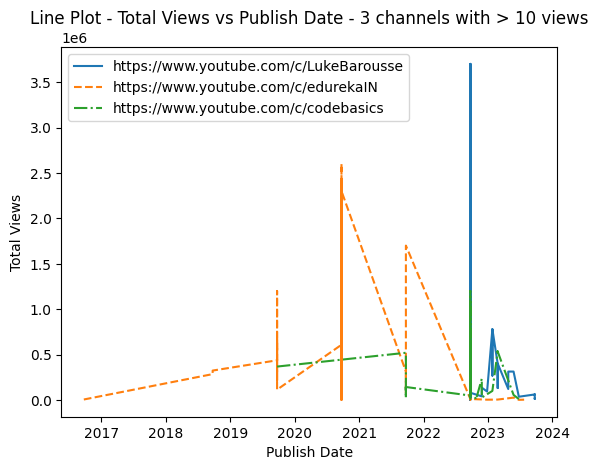

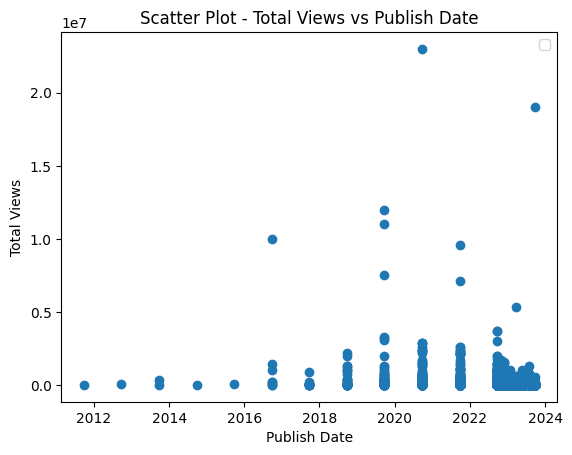

In [256]:
if __name__ == '__main__':
    filename = "HW03_Kaggle_Youtube_DataScience.csv"
    do_stuff(filename)